## Import Packages and Set Directories

In [1]:
# Import packages
import os
import sys
import inspect
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from datetime import timedelta
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split


# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
factor_dir = os.path.join(base_dir, 'data', 'processed', 'factors')
sample_dir = os.path.join(base_dir, 'data', 'processed', 'sample_stock')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Import optimal portfolio
from optimal_portfolios import OptimalPortfolios

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

## Read in Data

In [2]:
df_full = pd.read_csv(os.path.join(data_dir, 'covariates_weekly.csv'))
df = df_full.drop(columns=['IA', 'ME'])  # IA is equivalent to CMA, ME is equivalent to SMB

## 1. Stepwise and Best Subset Selection

### 1.1 Define Functions for Forward and Best Subset Selection

In [3]:
def forward_selection(X, y, criterion='aic', verbose=True):
    """ Perform forward feature selection based on AIC or BIC
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        criterion - 'aic' or 'bic' as the criterion for feature selection
        verbose - whether to print the sequence of inclusions
    Returns: tuple of (list of selected features, best model)
    """
    included = []
    current_score = float('inf')
    best_model = None

    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_score = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
            new_score[new_column] = model.aic if criterion == 'aic' else model.bic
        best_score = new_score.min()
        if new_score is not None and (len(included) == 0 or best_score < current_score):
            best_feature = new_score.idxmin()
            included.append(best_feature)
            current_score = best_score                        
            changed = True
            if verbose:
                print('Add  {:10} with {} {:.6}'.format(best_feature, criterion.upper(), best_score))
        if not changed:
            best_model = sm.OLS(y, sm.add_constant(X[included])).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
            break

    return included, best_model


def best_subset_selection(X, y, criterion='aic'):
    """ Perform best subset selection based on AIC or BIC
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        criterion - 'aic' or 'bic' for the selection criterion
    Returns: tuple of (best model, best features)
    """
    best_score = float('inf')
    best_model = None
    best_features = None

    # Iterate over all possible combinations of predictors
    for k in range(1, len(X.columns) + 1):
        for subset in itertools.combinations(X.columns, k):
            X_subset = sm.add_constant(X[list(subset)])
            model = sm.OLS(y, X_subset).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
            score = model.aic if criterion == 'aic' else model.bic
            if score < best_score:
                best_score = score
                best_model = model
                best_features = subset

    return best_features, best_model


def get_data(df, phase):
    """ Extracts features (X) and target variables (Y) from the DataFrame for a specified phase.
    Parameters:
        df - The input DataFrame containing the data.
        phase (str) - The phase for which data is to be extracted.
    Returns: tuple: A tuple containing two DataFrames, features (X) and target variables (Y).
    """
    df_phase = df[df['Phase']==phase].copy().dropna(axis=1)    
    # Filter out covariates
    X_cols = df_phase.columns.difference(['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF', 'R4-RF', 'R5-RF'])
    X = df_phase[X_cols].reset_index(drop=True)
    # Use portfolio 3, 4 and 5 for depression. See optimal_portfolio_creation.ipynb for reason
    if phase == 'Depression':
        Y = df_phase[['R3-RF', 'R4-RF', 'R5-RF']].reset_index(drop=True)
    else:
        Y = df_phase[['R1-RF', 'R3-RF', 'R5-RF']].reset_index(drop=True)
    return X, Y


def get_feature_names(dict_in_list):
    """ Extracts a unique list of feature names from a list of dictionaries.
    Parameters (dict_in_list): A list of dictionaries with phase names as keys and feature lists as values.
    Returns: list: A list of unique feature names.
    """
    feature_names = set()
    for phase_dict in best_list:
        for features in phase_dict.values():
            feature_names.update(features)
    feature_names = list(feature_names)
    return feature_names

### 1.2 Run Forward Selection and Best Subset Selection

In [23]:
# Use 3 (low, mid, high) portfolio in each phase
num_pfos = 3
phases = ['Recovery', 'Expansion', 'Downturn', 'Depression']

# Forward selection
forward_selected = {}
forward_models = {}
for phase in phases:    
    X, Y = get_data(df_full, phase)
    # Loop over portfolios
    for p in range(num_pfos):
        y = Y.iloc[:, p]
        # Forward selection
        forward_features, fowrward_model = forward_selection(X, y, verbose=False) 
        # Add the selected list of features to dictionary
        phase_pfo = phase + '_' + str(p+1)
        forward_selected[phase_pfo] = sorted(forward_features)
        forward_models[phase_pfo] = fowrward_model
print(f"\n***Selected Features Using Forward Selection***\n")    
display(forward_selected)


# Best subset selection
best_selected = {}  
best_models = {}
for phase in phases:
    X, Y = get_data(df_full, phase)
    for p in range(num_pfos):
        y = Y.iloc[:, p]
        best_features, best_model = best_subset_selection(X, y) 
        phase_pfo = phase + '_' + str(p+1)
        best_selected[phase_pfo] = sorted(list(best_features))
        best_models[phase_pfo] = best_model
print(f"\n***Selected Features Using Best Subset Selection***\n")    
display(best_selected)


***Selected Features Using Forward Selection***



{'Recovery_1': ['CMA', 'EG', 'LIQ', 'ME', 'Mkt-RF', 'ROE'],
 'Recovery_2': ['CMA', 'EG', 'LIQ', 'ME', 'Mkt-RF'],
 'Recovery_3': ['CMA', 'EG', 'LIQ', 'ME', 'Mkt-RF'],
 'Expansion_1': ['CRD', 'EG', 'HML', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'Expansion_2': ['EG', 'HML', 'IA', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Expansion_3': ['EG', 'HML', 'IA', 'LIQ', 'Mkt-RF', 'RMW', 'SMB'],
 'Downturn_1': ['CMA', 'CRD', 'HML', 'IA', 'LIQ', 'Mkt-RF', 'RMW', 'SMB'],
 'Downturn_2': ['CMA',
  'CRD',
  'HML',
  'IA',
  'LIQ',
  'MOM',
  'Mkt-RF',
  'RMW',
  'SMB'],
 'Downturn_3': ['IA', 'LIQ', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'Depression_1': ['EG', 'LIQ', 'ME', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Depression_2': ['EG', 'LIQ', 'ME', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Depression_3': ['EG', 'LIQ', 'ME', 'Mkt-RF', 'RMW', 'ROE', 'SMB']}


***Selected Features Using Best Subset Selection***



{'Recovery_1': ['CMA', 'CRD', 'EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Recovery_2': ['CMA', 'EG', 'LIQ', 'ME', 'Mkt-RF'],
 'Recovery_3': ['CMA', 'EG', 'LIQ', 'ME', 'Mkt-RF'],
 'Expansion_1': ['CMA',
  'CRD',
  'EG',
  'HML',
  'IA',
  'MOM',
  'Mkt-RF',
  'RMW',
  'SMB'],
 'Expansion_2': ['EG', 'HML', 'IA', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Expansion_3': ['EG', 'HML', 'IA', 'LIQ', 'Mkt-RF', 'RMW', 'SMB'],
 'Downturn_1': ['CRD', 'HML', 'IA', 'LIQ', 'Mkt-RF', 'RMW', 'SMB'],
 'Downturn_2': ['CRD', 'HML', 'IA', 'LIQ', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'Downturn_3': ['IA', 'LIQ', 'MOM', 'Mkt-RF', 'RMW', 'SMB'],
 'Depression_1': ['CMA', 'EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Depression_2': ['EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB'],
 'Depression_3': ['EG', 'LIQ', 'Mkt-RF', 'RMW', 'ROE', 'SMB']}

### 1.3 Define Functions to Generate Plots and Tables for Regression Results

In [25]:
def plot_feature_selection(feature_list, title, feature_names, save_path=None, size=(5, 4)):
    """
    Plots a feature selection chart showing the presence of features in different phases and portfolios.

    Parameters:
    feature_list (dict): Dictionary with phases and selected features.
    title (str): Title for the plot.
    save_path (str, optional): Path to save the plot. If None, the plot is displayed.
    """    
    flattened_data = {}
    # feature_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'CRD', 'LIQ']
    # Create a DataFrame for plotting
    for phase, features in feature_list.items():
        for feature in feature_names:
            flattened_data.setdefault(phase, []).append(feature in features)
    df_plot = pd.DataFrame(flattened_data, index=feature_names)       
    plt.figure(figsize=size)
    ax = plt.gca()
    
    # Create a color matrix corresponding to the data values
    color_map = {'Recovery': 'olivedrab', 'Expansion': 'tomato', 'Downturn': 'steelblue', 'Depression': 'firebrick'}
    color_matrix = np.zeros((len(df_plot.index), len(df_plot.columns), 4))
    for col_idx, col in enumerate(df_plot.columns):
        phase_color = color_map[col.split('_')[0]]
        for row_idx, value in enumerate(df_plot[col]):
            if value:
                color_matrix[row_idx, col_idx] = mcolors.to_rgba(phase_color)
            else:
                color_matrix[row_idx, col_idx] = mcolors.to_rgba('white')
    ax.imshow(color_matrix, aspect='auto')

    # Setting up grid lines for separation
    ax.set_xticks(np.arange(len(df_plot.columns))-0.5, minor=True)
    ax.set_yticks(np.arange(len(df_plot.index))-0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(axis='x', which='major', length=0)
    new_x_labels = ['Low', 'Mid', 'High'] * 4

    # Setting x and y ticks with new labels and smaller font size
    plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False, labelsize=8)
    plt.xticks(ticks=np.arange(len(df_plot.columns)), labels=new_x_labels)
    plt.yticks(ticks=np.arange(len(df_plot.index)), labels=df_plot.index, fontsize=8)

    # Add legend with smaller font size
    legend_elements = [Patch(facecolor=color, label=phase) for phase, color in color_map.items()]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(color_map), fontsize=8)
    plt.title(title, pad=30, fontsize=10)
    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(graph_dir, save_path), bbox_inches='tight')
    else:
        plt.show()

        
def create_coef_df(model_dict, row_order, num_pfo=3):
    """
    Creates a DataFrame with formatted coefficients and adjusted R-squared for multiple models.
    For each phase and portfolio in the provided model dictionary, extracts coefficients,
    formats them with significance, and computes adjusted R-squared values.
    
    Parameters:
    model_dict (dict): Dictionary containing statistical models for each phase and portfolio.
    num_pfo (int, optional): Number of portfolios. Default is 3.

    Returns:
    DataFrame: DataFrame with coefficients and adjusted R-squared values for each model.
    """
    phases = ['Recovery', 'Expansion', 'Downturn', 'Depression']
    best_coef_list = []
    adj_r_squared = {}
    
    for phase in phases:
        for p in range(num_pfo):            
            # Get coefficeints and p-value
            pfo_str = phase + '_' + str(p+1)
            model_tmp = model_dict[pfo_str]
            coefs = model_tmp.params
            pvalues = model_tmp.pvalues            
            tvalues = model_tmp.tvalues
            # Format coefficients with parameters and significance
            formatted_coefs = coefs.apply(lambda x: f"{x:.3f}" +
                                          ("***" if pvalues[coefs.index[coefs.tolist().index(x)]] < 0.01 else 
                                           "**" if pvalues[coefs.index[coefs.tolist().index(x)]] < 0.05 else 
                                           "*" if pvalues[coefs.index[coefs.tolist().index(x)]] < 0.1 else ""))
            df_tmp = pd.DataFrame({pfo_str: formatted_coefs})
            best_coef_list.append(df_tmp)                
            adj_r_squared[pfo_str] = model_tmp.rsquared_adj  
            
    # Create df for best coefs
    # row_order = ['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'CRD', 'LIQ']        
    best_coef_df = pd.concat(best_coef_list, axis=1)    
    best_coef_df = best_coef_df.reindex(row_order).fillna('')
    
    # Add a row for adjusted r-squared
    adj_r_squared_row = np.round(pd.Series(adj_r_squared, name='Adj.R2'), 3)
    best_coef_df = best_coef_df.append(adj_r_squared_row)
    best_coef_df.columns = ['REC_LOW', 'REC_MID', 'REC_HIGH', 'EXP_LOW', 'EXP_MID', 'EXP_HIGH',
                            'DWN_LOW', 'DWN_MID', 'DWN_HIGH', 'DEP_LOW', 'DEP_MID', 'DEP_HIGH']
    return best_coef_df

### 1.4 Summary: forward selection selected features and best subset selected features

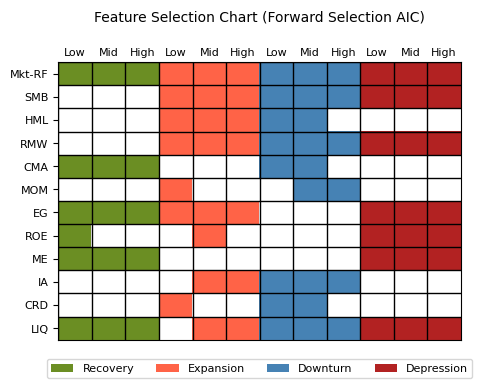

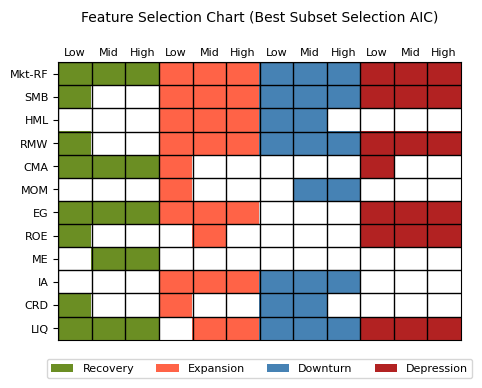


***Coefficients and Adjusted R-squared for Forward Selection***



,REC_LOW,REC_MID,REC_HIGH,EXP_LOW,EXP_MID,EXP_HIGH,DWN_LOW,DWN_MID,DWN_HIGH,DEP_LOW,DEP_MID,DEP_HIGH
Mkt-RF,0.624***,0.637***,0.669***,0.799***,0.840***,0.896***,0.661***,0.713***,0.788***,0.909***,0.904***,0.899***
SMB,,,,0.320***,0.348***,0.387***,0.109***,0.124***,0.177***,0.369,0.407*,0.419*
HML,,,,0.261***,0.306***,0.323***,-0.116**,-0.088,,,,
RMW,,,,0.319***,0.358***,0.271***,0.222***,0.233***,0.207***,0.353***,0.317***,0.279**
CMA,0.210***,0.206**,0.184*,,,,0.076,0.057,,,,
MOM,,,,-0.057,,,,0.050,0.096**,,,
EG,-0.131,-0.084,-0.103,0.093*,0.165***,0.245***,,,,-0.319**,-0.340**,-0.350**
ROE,0.088*,,,,-0.088,,,,,0.213**,0.274**,0.324**
ME,0.169***,0.189***,0.222***,,,,,,,0.103,0.058,0.041
IA,,,,,-0.097,-0.172**,0.145,0.134,0.097*,,,



***Coefficients and Adjusted R-squared for Best Subset Selection***



,REC_LOW,REC_MID,REC_HIGH,EXP_LOW,EXP_MID,EXP_HIGH,DWN_LOW,DWN_MID,DWN_HIGH,DEP_LOW,DEP_MID,DEP_HIGH
Mkt-RF,0.633***,0.637***,0.669***,0.800***,0.840***,0.896***,0.661***,0.713***,0.788***,0.917***,0.907***,0.901***
SMB,0.161**,,,0.313***,0.348***,0.387***,0.113***,0.127***,0.177***,0.459***,0.464***,0.459***
HML,,,,0.252***,0.306***,0.323***,-0.113**,-0.087,,,,
RMW,-0.129,,,0.339***,0.358***,0.271***,0.225***,0.236***,0.207***,0.299**,0.318***,0.280**
CMA,0.228**,0.206**,0.184*,0.163,,,,,,0.113,,
MOM,,,,-0.051,,,,0.049,0.096**,,,
EG,-0.095,-0.084,-0.103,0.086*,0.165***,0.245***,,,,-0.317**,-0.346***,-0.354***
ROE,0.179***,,,,-0.088,,,,,0.233**,0.283**,0.330***
ME,,0.189***,0.222***,,,,,,,,,
IA,,,,-0.147,-0.097,-0.172**,0.202***,0.178**,0.097*,,,


In [26]:
# Plot forward selection
title = 'Feature Selection Chart (Forward Selection AIC)'
save_path = 'forward_selection_chart.png'
feature_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'ME', 'IA', 'CRD', 'LIQ']
plot_feature_selection(forward_selected, title, feature_names)

# Plot best subset selection
title = 'Feature Selection Chart (Best Subset Selection AIC)'
save_path = 'bestsubset_selection_chart.png'
plot_feature_selection(best_selected, title, feature_names)

# Show forward selection coefficients
row_order = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'ME', 'IA', 'CRD', 'LIQ']
forward_coef = create_coef_df(forward_models, row_order)
print(f"\n***Coefficients and Adjusted R-squared for Forward Selection***\n")
display(forward_coef)

# Show best subset selection coefficients
best_coef = create_coef_df(best_models, row_order)
print(f"\n***Coefficients and Adjusted R-squared for Best Subset Selection***\n")
display(best_coef)

## 2. Lasso Regression

In [7]:
# # Lasso function with various lambda values
# def lasso_model(X, y, lam):
#     model = Lasso(alpha=lam)
#     model.fit(X, y)
#     return model

# # function to make coefficients with various lambdas
# def make_coef_df(filename, lambdas, target):
#     # read the data
#     df = pd.read_csv("data/processed/"+filename)
#     # make X and y
#     X = df.drop(["Year_Week", "Phase", "R1-RF", "R2-RF", "R3-RF"], axis=1)
#     col_names = X.columns
#     y = df[target]
#     # standardization
#     scaler = StandardScaler().fit(X) 
#     X = pd.DataFrame(scaler.transform(X), columns=col_names)
#     coefs = []
#     for lam in lambdas:
#         model = lasso_model(X, y, lam)
#         coefs.append(model.coef_) 
#     coefs = pd.DataFrame(coefs, index=lambdas, columns=X.columns)
#     return coefs

# # function to calculate adjusted R square
# def adj_r2_score(y_true, y_pred, p):
#     return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)

# # function to make the best model and return lambda, constant, coefficients, and adjusted R square in dictionary
# def make_lasso_dict(filename, target):
#     # read the data
#     df = pd.read_csv("data/processed/"+filename)
    
#     # make X and y
#     X = df.drop(["Year_Week", "Phase", "R1-RF", "R2-RF", "R3-RF"], axis=1)
#     y = df[target]

#     # make model
#     scaler = StandardScaler()
#     scaler.fit(X)
#     model = LassoCV(alphas=np.geomspace(start=10**-3, stop=1.5, num=30), cv=5)
#     model.fit(scaler.transform(X), y)

#     # calculate adjusted R square
#     y_pred = model.predict(scaler.transform(X))
#     adj_r2 = adj_r2_score(y, y_pred, p=X.shape[1])

#     return {"lam":model.alpha_, "const":model.intercept_, "coef":model.coef_, "adf_R2":adj_r2}


# res = pd.DataFrame(index=["R1-RF", "R2-RF", "R3-RF"], columns=["Rec", "Exp", "Dwt", "Dep"])
# filepath_dict = {"Rec":"recovery_factor_candidates.csv", "Exp":"expansion_factor_candidates.csv",\
#                  "Dwt":"downturn_factor_candidates.csv", "Dep":"depression_factor_candidates.csv"}
# for target in res.index:
#     for cycle in res.columns:
#         res.at[target, cycle] = make_lasso_dict(filepath_dict[cycle], target)
# res.index = ["Low", "Mid", "High"]


# idx_names = ["const"] + list(coef_dwt.columns) + ["lambda", "Adj R^2"]
# result_df = pd.DataFrame(index=idx_names)
# for col in res.columns:
#     for i in res.index:
#         r = res.loc[i, col]
#         result_df.loc["const", col+"-"+i] = r["const"]
#         result_df.loc["CMA":"PC8", col+"-"+i] = list(r["coef"]) + [np.nan]*(20-len(r["coef"]))
#         result_df.loc["lambda", col+"-"+i] = r["lam"]
#         result_df.loc["Adj R^2", col+"-"+i] = r["adf_R2"]
# result_df

### 2.1 Define Functions for Cross Validation and Lasso

In [8]:
def create_fold_column(input_df):
    """
    Adds a 'Fold' column to the DataFrame based on weekly jumps in the 'Year_Week' column.
    
    Parameters:
    input_df (DataFrame): DataFrame with 'Year_Week' and 'Phase' columns.
    
    Returns:
    DataFrame: Modified DataFrame with an additional 'Fold' column.
    """
    df_fold = input_df.copy()
    df_fold['Year_Week'] = pd.to_datetime(df_fold['Year_Week'] + '-0', format='%Y-%W-%w')
    def create_fold(group):
        group = group.sort_values(by='Year_Week')  # Ensure the data is sorted by 'Year_Week'
        group['Fold'] = (group['Year_Week'].diff() > timedelta(weeks=1)).cumsum()
        return group
    df_fold = df_fold.groupby('Phase').apply(create_fold).reset_index(drop=True)
    df_fold['Year_Week'] = df_fold['Year_Week'].apply(lambda x: x.strftime('%Y-%W'))    
    return df_fold


def create_lasso_alphas(df):
    """
    Calculates optimal alpha values for Lasso regression for each phase and portfolio.
    
    Splits the data by phase and uses LassoCV to find optimal alpha for each response column.
    
    Parameters:
    df (DataFrame): DataFrame with data for Lasso regression.
    
    Returns:
    dict: Dictionary with keys as phase_portfolio and optimal alpha as values.
    """
    df_fold = create_fold_column(df)        
    phases = ['Recovery', 'Expansion', 'Downturn', 'Depression']                  
    best_alphas = {}  # Store the best alphas in dictionary
    for phase in phases:    
        # Seperate X and Y (function defined in 1.1) 
        X, Y = get_data(df_fold, phase)
        # Determine fold index and drop Fold column
        ps = PredefinedSplit(test_fold = X['Fold'])
        X.drop(columns=['Fold'], inplace=True)
        # Calculate best alpha for lasso
        for i, col in enumerate(Y.columns):
            lasso_cv = LassoCV(cv=ps, random_state=69).fit(X, Y[col])
            best_alphas[phase+'_'+str(i+1)] = lasso_cv.alpha_
    return best_alphas


def fit_lasso(df, lasso_alphas, row_order, num_pfo=3):
    """
    Fits Lasso models for specified phases and portfolios, returning coefficients and adjusted R-squared.
    For each phase and portfolio, fits a Lasso model using predetermined alphas. 
    It collects the non-zero coefficients and calculates adjusted R-squared values.

    Parameters:
    df (DataFrame): DataFrame with feature and target data.
    lasso_alphas (dict): Dictionary of optimal alpha values for Lasso models.
    num_pfo (int, optional): Number of portfolios. Default is 3.

    Returns:
    tuple: DataFrame of Lasso coefficients and a dictionary of non-zero coefficient names by phase_portfolio.
    """
    phases = ['Recovery', 'Expansion', 'Downturn', 'Depression']        
    lasso_coefs_dict = {}
    adj_r_squared = {}
    lasso_coefs_list = []
    
    for phase in phases:
        for p in range(num_pfo):
            # Get variables and best alpha
            X, Y = get_data(df, phase)
            phase_str = phase + '_' + str(p+1)
            alpha = lasso_alphas[phase_str]

            # Fit Lasso and store coefficients
            lasso = Lasso(alpha=alpha).fit(X, Y.iloc[:, p])
            coef = pd.Series(data=lasso.coef_, index=X.columns)
            lasso_coefs_dict[phase_str] = coef[coef != 0].index.tolist()

            # Add the intercept
            coef['const'] = lasso.intercept_
            coef_df = pd.DataFrame(coef, columns=[phase_str])
            lasso_coefs_list.append(coef_df)

            # Calculate R-squared and Adjusted R-squared
            r2 = lasso.score(X, Y.iloc[:, p])
            n, p = X.shape[0], sum(lasso.coef_ != 0)
            adjusted_r2 = 1 - (1-r2) * (n-1) / (n-p-1)
            adj_r_squared[phase_str] = adjusted_r2

    # Create a dataframe for lasso coefficients
    # row_order = ['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'CRD', 'LIQ']        
    lasso_coefs_df = np.round(pd.concat(lasso_coefs_list, axis=1), 3)
    lasso_coefs_df = lasso_coefs_df.reindex(row_order).replace(0, '')

    # Add adjusted r-squared
    adj_r_squared_row = np.round(pd.Series(adj_r_squared, name='Adj.R2'), 3)
    lasso_coefs_df = lasso_coefs_df.append(adj_r_squared_row)
    return lasso_coefs_df, lasso_coefs_dict

### 2.2 Fit Lasso


***Lasso Hyperparameter Determined by Cross Validation***



{'Recovery_1': 0.07896707872639101,
 'Recovery_2': 0.0937960682165446,
 'Recovery_3': 0.1496908453625146,
 'Expansion_1': 0.2961581974907626,
 'Expansion_2': 0.4245423484837745,
 'Expansion_3': 0.46331836661836284,
 'Downturn_1': 0.0538605138613964,
 'Downturn_2': 0.23740295787408375,
 'Downturn_3': 0.3373445861862946,
 'Depression_1': 0.1558568168254163,
 'Depression_2': 0.12754485258823156,
 'Depression_3': 0.1048945564849494}


***Selected Features for Lasso Regression***



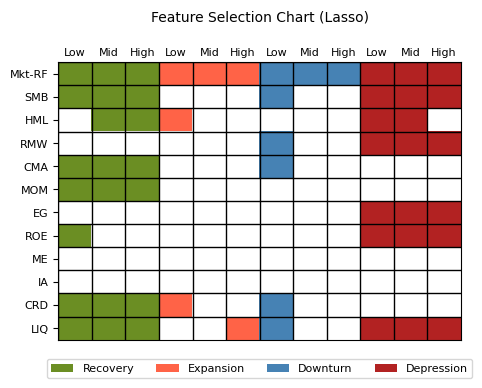


***Coefficients and Adjusted R-squared for Lasso***



,Recovery_1,Recovery_2,Recovery_3,Expansion_1,Expansion_2,Expansion_3,Downturn_1,Downturn_2,Downturn_3,Depression_1,Depression_2,Depression_3
const,0.231,0.474,0.702,0.203,0.402,0.552,0.146,0.313,0.462,0.296,0.364,0.427
Mkt-RF,0.573,0.588,0.589,0.578,0.627,0.676,0.619,0.57,0.643,0.893,0.89,0.887
SMB,0.135,0.155,0.171,,,,0.044,,,0.418,0.424,0.427
HML,,0.016,0.032,0.072,,,,,,0.05,0.017,
RMW,,,,,,,0.123,,,0.209,0.223,0.216
CMA,0.15,0.108,0.029,,,,0.058,,,,,
MOM,0.016,0.025,0.024,,,,,,,,,
EG,,,,,,,,,,-0.055,-0.133,-0.186
ROE,0.002,,,,,,,,,0.087,0.158,0.223
ME,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Calculate best hyperparameters using cross validation
best_alphas = create_lasso_alphas(df)
print(f"\n***Lasso Hyperparameter Determined by Cross Validation***\n")    
display(best_alphas)

# Fit lasso
row_order = ['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'ME', 'IA', 'CRD', 'LIQ']
lasso_df, lasso_dict = fit_lasso(df, best_alphas, row_order)

# Plot the selected features using lasso
title = 'Feature Selection Chart (Lasso)'
save_path = 'lasso_chart.png'
feature_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'ME', 'IA', 'CRD', 'LIQ']
print(f"\n***Selected Features for Lasso Regression***\n")
plot_feature_selection(lasso_dict, title, feature_names)

# Show Lasso coefficients
print(f"\n***Coefficients and Adjusted R-squared for Lasso***\n")
display(lasso_df)

## 3. Adding Principal Components

### 3.1 Calculate Principal Components

In [10]:
class PhasePCA:
    def __init__(self, df_full, num_pcs):
        self.df_full = df_full
        self.col_to_keep = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'ME', 'IA', 'CRD', 'LIQ']
        self.num_pcs = num_pcs
        self.pcas = {}
        self.loadings = {}
        self.explained_variance_ratios = {}

        for phase in self.num_pcs.keys():
            self._fit_pca(phase)

    def _fit_pca(self, phase):
        scaler = StandardScaler()        
        current_factors = self.df_full[self.df_full['Phase'] == phase][self.col_to_keep].copy()
        current_factors = pd.DataFrame(scaler.fit_transform(current_factors), columns=self.col_to_keep)                
        num_pc = self.num_pcs[phase]
        pca = PCA(n_components=num_pc)
        pca.fit(current_factors)

        self.pcas[phase] = pca
        self.loadings[phase] = pd.DataFrame(pca.components_, columns=self.col_to_keep, 
                                            index=['PC' + str(i + 1) for i in range(num_pc)])
        self.explained_variance_ratios[phase] = pca.explained_variance_ratio_

    def get_pc(self, phase):
        scaler = StandardScaler()        
        current_factors = self.df_full[self.df_full['Phase'] == phase][self.col_to_keep].copy()
        current_factors = pd.DataFrame(scaler.fit_transform(current_factors), columns=self.col_to_keep)
        pca = self.pcas[phase]
        return pd.DataFrame(pca.transform(current_factors), columns=['PC' + str(i + 1) for i in range(pca.n_components)])

    def get_evr(self, phase):
        return self.explained_variance_ratios[phase]

    def get_loading(self, phase):
        return self.loadings[phase]

In [11]:
# Number of principal components to include in each pahse, see PCA.ipynb for details
num_pcs = {'Recovery': 5, 'Expansion': 7, 'Downturn': 8, 'Depression': 7}

# Initiate PhasePCA class
phase_pca = PhasePCA(df_full, num_pcs)

# Fit PCA for each phase
full_pc_dfs = []
for phase in num_pcs.keys():
    df_current = df_full[df_full['Phase']==phase].copy().reset_index(drop=True)
    current_pc = phase_pca.get_pc(phase)
    full_pc_dfs.append(pd.concat([df_current, current_pc], axis=1))

df_full_pc = pd.concat(full_pc_dfs, axis=0)
print(df_full_pc.shape)

(1728, 27)


### 3.3 Forward Selection with PCA and original covariates

Forward AIC with PC inlcuded

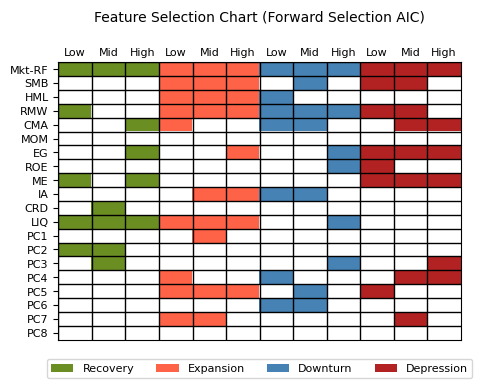


***Coefficients and Adjusted R-squared for Forward Selection***



,Recovery_1,Recovery_2,Recovery_3,Expansion_1,Expansion_2,Expansion_3,Downturn_1,Downturn_2,Downturn_3,Depression_1,Depression_2,Depression_3
const,0.211***,0.490***,0.690***,0.077*,0.223***,0.374***,0.106***,0.250***,0.455***,0.315***,0.545***,0.613***
Mkt-RF,0.657***,0.667***,0.669***,0.840***,0.922***,0.926***,0.638***,0.766***,0.782***,0.941***,0.738***,0.817***
SMB,,,,0.287***,0.522***,0.430***,,0.066*,,0.440**,0.356,
HML,,,,0.274***,0.313***,0.375***,-0.110**,,,,,
RMW,-0.154,,,0.390***,0.386***,0.432***,0.109*,0.361***,0.222***,0.351***,-0.019,
CMA,,,0.184*,0.176,,,0.175,0.095,,,0.317**,0.306***
MOM,,,,,,,,,,,,
EG,,,-0.103,,,0.128,,,-0.093,-0.386***,-0.551***,-0.560***
ROE,,,,,,,,,-0.162*,0.239**,,
ME,0.122*,,0.222***,,,,,,,0.054,0.152,0.344**


In [12]:
# Use 3 (low, mid, high) portfolio in each phase
num_pfos = 3
phases = ['Recovery', 'Expansion', 'Downturn', 'Depression']

# Forward selection
forward_selected = {}
forward_models = {}
for phase in phases:    
    X, Y = get_data(df_full_pc, phase)
    # Loop over portfolios
    for p in range(num_pfos):
        y = Y.iloc[:, p]
        # Forward selection
        forward_features, fowrward_model = forward_selection(X, y, verbose=False) 
        # Add the selected list of features to dictionary
        phase_pfo = phase + '_' + str(p+1)
        forward_selected[phase_pfo] = sorted(forward_features)
        forward_models[phase_pfo] = fowrward_model
# print(f"\n***Selected Features Using Forward Selection***\n")    
# display(forward_selected)

# Feature names and row orders
feature_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'ME', 'IA', 'CRD', 'LIQ', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']
row_order = ['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'ME', 'IA', 'CRD', 'LIQ', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']        

# Plot forward selection
title = 'Feature Selection Chart (Forward Selection AIC)'
save_path = 'forward_selection_chart.png'
plot_feature_selection(forward_selected, title, feature_names)

# Show forward selection coefficients
forward_coef = create_coef_df(forward_models, row_order)
print(f"\n***Coefficients and Adjusted R-squared for Forward Selection***\n")
display(forward_coef)

### 3.5 Lasso with PCA included


***Lasso Hyperparameter Determined by Cross Validation***



{'Recovery_1': 0.06405263217237217,
 'Recovery_2': 0.076080882737292,
 'Recovery_3': 0.18454587062950262,
 'Expansion_1': 0.2961581974907626,
 'Expansion_2': 0.24293874049881395,
 'Expansion_3': 0.02005594606232216,
 'Downturn_1': 0.01891145910707146,
 'Downturn_2': 0.23740295787408375,
 'Downturn_3': 0.3373445861862946,
 'Depression_1': 0.20603353943045027,
 'Depression_2': 0.23899576697598762,
 'Depression_3': 0.5597906989509563}


***Selected Features for Lasso Regression***



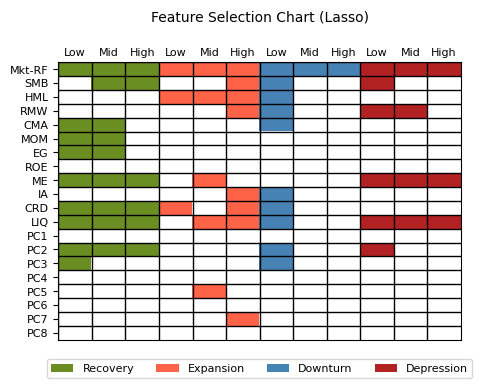


***Coefficients and Adjusted R-squared for Lasso***



,Recovery_1,Recovery_2,Recovery_3,Expansion_1,Expansion_2,Expansion_3,Downturn_1,Downturn_2,Downturn_3,Depression_1,Depression_2,Depression_3
const,0.225,0.46,0.689,0.203,0.379,0.436,0.138,0.313,0.462,0.293,0.356,0.471
Mkt-RF,0.593,0.606,0.582,0.578,0.678,0.808,0.646,0.57,0.643,0.865,0.852,0.818
SMB,,0.036,0.029,,,0.291,0.071,,,0.075,,
HML,,,,0.072,0.05,0.243,-0.072,,,,,
RMW,,,,,,0.258,0.191,,,0.175,0.181,
CMA,0.079,0.066,,,,,0.046,,,,,
MOM,0.007,0.021,,,,,,,,,,
EG,-0.003,-0.016,,,,,,,,,,
ROE,,,,,,,,,,,,
ME,0.104,0.131,0.134,,0.052,,,,,0.293,0.398,0.281


In [13]:
# Calculate best hyperparameters using cross validation
best_alphas = create_lasso_alphas(df_full_pc)
print(f"\n***Lasso Hyperparameter Determined by Cross Validation***\n")    
display(best_alphas)

# Fit lasso
row_order = ['const', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'ME', 'IA', 'CRD', 'LIQ', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']
lasso_df, lasso_dict = fit_lasso(df_full_pc, best_alphas, row_order)

# Plot the selected features using lasso
title = 'Feature Selection Chart (Lasso)'
save_path = 'lasso_chart.png'
feature_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'ME', 'IA', 'CRD', 'LIQ', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']        
print(f"\n***Selected Features for Lasso Regression***\n")
plot_feature_selection(lasso_dict, title, feature_names)

# Show Lasso coefficients
print(f"\n***Coefficients and Adjusted R-squared for Lasso***\n")
display(lasso_df)

## 4. Random Forest

In [14]:
def random_forest_selection(df, phase, importance_threshold=0.9):
    """
    Perform feature selection using a tuned Random Forest model for each response variable Y with cross-validation.
    Select features based on cumulative importance threshold.
    Arguments:
        df - DataFrame with the entire dataset
        phase - The phase for which to perform feature selection
        importance_threshold - Threshold for cumulative importance (default: 0.9)
    Returns:
        Dict: Dictionary with selected features for each response variable Y in the given phase
    """
    df_fold = create_fold_column(df)
    X, Y = get_data(df_fold, phase)
    selected_features_per_Y = {}

    # Hyperparameters to tune
    param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 20, 30]}
    print(f"\n***Running Random Forest for {phase} Phase***")
    
    for col in Y.columns:
        y = Y[col]
        X_without_fold = X.drop(columns=['Fold'])

        # Setting up the grid search with cross-validation        
        grid_search = GridSearchCV(estimator = RandomForestRegressor(max_features='sqrt', random_state=69),
                                   param_grid = param_grid,
                                   cv = PredefinedSplit(test_fold=X['Fold']),
                                   n_jobs = -1, verbose = 1)
        grid_search.fit(X_without_fold, y)
        
        # Train the model with the best parameters
        best_model = grid_search.best_estimator_
        importances = best_model.feature_importances_

        # Sort features by importance and select based on cumulative importance
        indices = np.argsort(importances)[::-1]
        sorted_features = X_without_fold.columns[indices]
        cumulative_importance = np.cumsum(importances[indices])        
        selected_features = sorted_features[cumulative_importance <= importance_threshold]
        selected_features_per_Y[col] = list(selected_features)

    return selected_features_per_Y


***Running Random Forest for Recovery Phase***
Fitting 6 folds for each of 12 candidates, totalling 72 fits
Fitting 6 folds for each of 12 candidates, totalling 72 fits
Fitting 6 folds for each of 12 candidates, totalling 72 fits

***Running Random Forest for Expansion Phase***
Fitting 13 folds for each of 12 candidates, totalling 156 fits
Fitting 13 folds for each of 12 candidates, totalling 156 fits
Fitting 13 folds for each of 12 candidates, totalling 156 fits

***Running Random Forest for Downturn Phase***
Fitting 13 folds for each of 12 candidates, totalling 156 fits
Fitting 13 folds for each of 12 candidates, totalling 156 fits
Fitting 13 folds for each of 12 candidates, totalling 156 fits

***Running Random Forest for Depression Phase***
Fitting 9 folds for each of 12 candidates, totalling 108 fits
Fitting 9 folds for each of 12 candidates, totalling 108 fits
Fitting 9 folds for each of 12 candidates, totalling 108 fits


{'Recovery_R1-RF': ['Mkt-RF', 'SMB', 'HML', 'EG', 'LIQ', 'ROE', 'MOM'],
 'Recovery_R3-RF': ['Mkt-RF', 'SMB', 'EG', 'LIQ', 'HML', 'ROE', 'MOM'],
 'Recovery_R5-RF': ['Mkt-RF', 'SMB', 'LIQ', 'EG', 'HML', 'ROE', 'MOM'],
 'Expansion_R1-RF': ['Mkt-RF', 'LIQ', 'MOM', 'SMB', 'HML', 'EG', 'RMW'],
 'Expansion_R3-RF': ['Mkt-RF', 'LIQ', 'MOM', 'CRD', 'RMW', 'SMB'],
 'Expansion_R5-RF': ['Mkt-RF', 'LIQ', 'MOM', 'CRD', 'RMW', 'CMA'],
 'Downturn_R1-RF': ['Mkt-RF', 'LIQ', 'EG', 'SMB', 'RMW', 'HML', 'MOM'],
 'Downturn_R3-RF': ['Mkt-RF', 'LIQ', 'SMB', 'EG', 'MOM', 'RMW', 'HML'],
 'Downturn_R5-RF': ['Mkt-RF', 'LIQ', 'SMB', 'MOM', 'EG', 'RMW', 'CMA'],
 'Depression_R3-RF': ['Mkt-RF', 'LIQ', 'EG', 'MOM', 'SMB', 'CRD'],
 'Depression_R4-RF': ['Mkt-RF', 'LIQ', 'EG', 'MOM', 'SMB', 'CRD', 'HML'],
 'Depression_R5-RF': ['Mkt-RF', 'LIQ', 'EG', 'MOM', 'SMB', 'CRD', 'HML']}

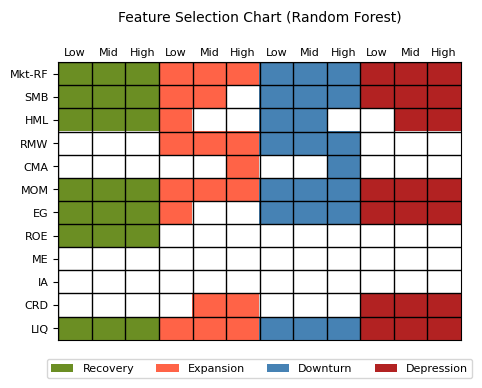

In [20]:
# Fit random forest for each phase
phases = ['Recovery', 'Expansion', 'Downturn', 'Depression']
rf_selected = {}
for phase in phases:
    selected_features_per_phase = random_forest_selection(df, phase)
    for Y_col, features in selected_features_per_phase.items():
        key = f"{phase}_{Y_col}"
        rf_selected[key] = features

display(rf_selected)

# Plot best subset selection
title = 'Feature Selection Chart (Random Forest)'
save_path = 'randomforest_selection_chart.png'
feature_names = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'EG', 'ROE', 'ME', 'IA', 'CRD', 'LIQ']
plot_feature_selection(rf_selected, title, feature_names)